# Comparison of binding operations

In [1]:
%matplotlib inline

In [2]:
from functools import partial
import os
import os.path

In [3]:
import matplotlib.pyplot as plt
import nengo_spa as spa
import numpy as np
import pandas as pd
from psyrun import map_pspace, map_pspace_parallel, Param
from scipy.stats import ortho_group
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint

In [4]:
def bootstrap_ci(data, func, n=10000, p=0.95):
    index = int(n * (1. - p) / 2.)
    r = func(np.random.choice(data, (n, len(data))), axis=1)
    r = np.sort(r)
    return r[index], r[-index]

In [5]:
def ci_l(x, func):
    return bootstrap_ci(x, func)[0]

def ci_u(x, func):
    return bootstrap_ci(x, func)[1]

statistic = lambda func: (func, partial(ci_l, func=func), partial(ci_u, func=func))

In [6]:
textwidth = 390.56151 / 72.27
row_height = textwidth / 1.5 / 1.6
single_fig_size = (textwidth / 1.5, row_height)


def save_tight_fig(fig, path, **kwargs):
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    fig.savefig(path, bbox_inches='tight', pad_inches=0., **kwargs)


weight = 'light'
sns.set('paper', 'ticks', None, rc={
    'axes.labelweight': weight,
    'axes.linewidth': 0.6,
    'axes.titleweight': weight,
    'font.cursive': ['cmsy10'],
    'font.sans-serif': ['Lato'],
    'font.weight': weight,
    'lines.linewidth': 1.,
    'lines.markersize': 4,
    'mathtext.fontset': 'custom',
})

In [7]:
def flatten(data):
    sizes = [len(d) for k in data for d in data[k] if hasattr(d, '__len__')]
    assert all(s == sizes[0] for s in sizes)
    return {k: sum((sizes[0] * [d] if not hasattr(d, '__len__') else d for d in data[k]), []) for k in data}

## Introduction

In models based on the Semantic Pointer Architecture (SPA), circular convolution has been classically used as binding operation. However, other operations like tensor products [1] and random permutations have been proposed (e.g. [2]). Furthermore, I propose a new binding method : vector-derived transformation matrices. This warrants a closer comparison of these operations. In the first part of this report definitions are provided and theoretical properties of these approaches are discussed. In the second part, a number of experiments are presented to further compare the binding operations.

[1]: Smolensky, Paul. “Tensor Product Variable Binding and the Representation of Symbolic Structures in Connectionist Systems.” Artificial Intelligence 46, no. 1 (November 1, 1990): 159–216. https://doi.org/10.1016/0004-3702(90)90007-M.

[2]: Gabriel Recchia, Magnus Sahlgren, Pentti Kanerva, and Michael N. Jones, “Encoding Sequential Information in Semantic Space Models: Comparing Holographic Reduced Representation and Random Permutation,” Computational Intelligence and Neuroscience, vol. 2015, Article ID 986574, 18 pages, 2015. doi:10.1155/2015/986574

## Binding operators

**Definition (compressed binding operator and approximate inverse)** A (compressed) binding operator is a function $\mathcal{B}: \mathbb{R}^{d} \times \mathbb{R}^{d} \rightarrow \mathbb{R}^{d}$ with an *approximate inverse* $\mathcal{B}^+: \mathbb{R}^{d} \times \mathbb{R}^{d} \rightarrow \mathbb{R}^{d}$ that satisfies $\mathcal{B}^+(\mathcal{B}(x, y), y) \approx x$.

We exclude non-compressed binding operations, like the tensor-product, here as they increase the dimensionality of the space with each binding. This gives scaling problems discussed elsewhere [2]. I will use *binding operator* and *compressed binding operator* interchangeably in this report.

**Definition (exact inverse)** The exact inverse $\mathcal{B}^{-1}: \mathbb{R}^{d} \times \mathbb{R}^{d} \rightarrow \mathbb{R}^{d}$ of a binding operator $\mathcal{B}$ is a function satisfying $\mathcal{B}^{-1}(\mathcal{B}(x, y), y) = x$.

**Definition (identity)** Any vector $y$ with the property $\mathcal{B}(x, y) = x$ is called *identity* under $\mathcal{B}$ and denoted with the symbol $i_{\mathcal{B}}$.

**Definition (unitary vector)** Any vector $u$ with the property $\langle\mathcal{B}(x, u), \mathcal{B}(y, u)\rangle = \langle x, y \rangle$ is called *unitary*. ($\langle x, y \rangle$ denotes the dot product of $x$ with $y$.)

Given a binding operator it can be used to encode pairs into trace $m$.

**Definition (encoding with binding)** Given $k$ pairs $(x_i, y_i) \in \mathbb{R}^d \times \mathbb{R}^d$, the encoding into a trace $m$ with binding is given by
$$ m = \sum_{i=1}^k \mathcal{B}(x_i, y_i) \text{.}$$

We usually want the binding operation to be *distributive*, i.e. $\mathcal{B}(x_1 + x_2, y) = \mathcal{B}(x_1, y) + \mathcal{B}(x_2, y)$, to allow to *recall* individual items from the trace. An $x_i$ can be *recalled* from such a trace with a distributive binding function as $x_i \approx \hat{x}_i := \mathcal{B}^+(m, x_i) = x_i + \mathit{noise}$.

In [8]:
class Binding(object):
    def identity(self, d):
        raise NotImplementedError()
        
    def bind(self, x, y):
        raise NotImplementedError()
        
    def unbind(self, x, y):
        raise NotImplementedError()
        
    def __hash__(self):
        return hash(type(self))
        
    def __eq__(self, other):
        return type(self) is type(other)

In [9]:
class Encoding(object):
    def __init__(self, d):
        super(Encoding, self).__init__()
        self.d = d
        
    def bind(self, xs, ys):
        """Return SemanticPointer of bound pairs created from *xs* and *ys*."""
        raise NotImplementedError()
        
    def retrieve(self, pointer, cue, vocab):
        """Retrieve vector bound to *cue* in *pointer* and return its index in *vocab*."""
        raise NotImplementedError()

In [10]:
def vocab_cosines(vocab, p):
    return vocab.dot(p.normalized()) / np.linalg.norm(vocab.vectors, axis=1)

class EncodeWithBinding(Encoding):
    def __init__(self, binding, d):
        super(EncodeWithBinding, self).__init__(d)
        self.binding = binding
        
    def __call__(self):
        return self
        
    def bind(self, xs, ys):
        return sum((self.binding.bind(x, y) for x, y in zip(xs, ys)), spa.pointer.Zero(self.d))
    
    def retrieve(self, pointer, cue, vocab, k=None):
        return np.argmax(vocab_cosines(vocab, self.binding.unbind(pointer, cue)))

### Circular convolution

**Definition (circular convolution)** Circular convolution is a binding operater $\mathcal{B}_{\circledast}$ defined by
$$ \mathcal{B}_{\circledast}(x, y) := x \circledast y\quad\text{and}\quad (x \circledast y)[i] = \sum_{j=0}^{d-1} x\left[j\right]\, y\left[(i-j)\ \mathrm{mod}\ d\right] \text{.}$$
The approximate inverse is given by
$$ \mathcal{B}_{\circledast}^+(x, y) = x \circledast y^+\quad\text{with}\quad y^+ = (y[0], y[d-1], y[d-2], \dots, y[1])^T \text{.}$$

Circular convolution as a binding operation has been [discussed in detail elsewhere](https://github.com/ctn-waterloo/internal_tech_reports/blob/master/Semantic%20Pointers%20and%20convolutions.ipynb). Nevertheless, it is worth to restate some important properties here.

* Circular convolution is distributive: $(x_1 + x_2) \circledast y = x_1 \circledast y + x_2 \circledast y$
* Circular convolution is associative: $(x \circledast y) \circledast z = x \circledast (y \circledast z)$
* Circular convolution is commutative: $x \circledast y = y \circledast x$
* There exist unitary vectors under circular convolution.
* The approximate inverse of any unitary vectors under circular convolution is equal to its exact inverse.

In [11]:
class CircularConvolution(Binding):
    def identity(self, d):
        return spa.semantic_pointer.Identity(d)
    
    def unitary(self, d, rng=None):
        return spa.SemanticPointer(d, rng=rng).unitary()
        
    def bind(self, x, y):
        return x * y
    
    def unbind(self, x, y):
        return x * ~y
    
    def __str__(self):
        return "Circular convolution"

### Vector-derived transformation binding (VTB)

**Definition (vector-derived transformation binding, VTB)** Vector-derived transformation binding is a binding operator $\mathcal{V}: \mathbb{R}^{d} \times \mathbb{R}^{d} \rightarrow \mathbb{R}^{d}$ with $d = \delta^2$ and $\delta \in \mathbb{N}_{>0}$ defined by
$$ \mathcal{V}(x, y) = V_y x = \left[ \begin{array}{ccc} V'_y & 0 & 0 \\ 0 & V'_y & 0 \\ 0 & 0 & \ddots \end{array} \right] x$$
with
$$ V'_y = d^{\frac{1}{4}} \left[ \begin{array}{cccc}
y_1 & y_2 & \dots & y_{\delta} \\
y_{\delta+1} & y_{\delta+2} & \dots & y_{2\delta} \\
\vdots & \vdots & \ddots & \vdots \\
y_{d - \delta + 1} & y_{d - \delta + 2} & \dots & y_d
\end{array} \right] \text{.} $$
The approximate inverse $\mathcal{V}^+$ is given by
$$ \mathcal{V}^+(x, y) = \left[ \begin{array}{ccc} V_y'^T & 0 & 0 \\ 0 & V_y'^T & 0 \\ 0 & 0 & \ddots \end{array} \right] x \text{.}$$

For randomly generated and uniformly distributed vectors with identically (but not necessarily indepentently) distributed component, each row (or column) in $V_y$ can be treated also as a randomly generated and uniformly distributed vector with identically distributed components. Given a sufficiently high-dimensional space pairs of random vectors will be almost always almost orthogonal. Thus, $V_y$ is almost orthogonal and $V_y^T V_y \approx I$.

If and only if $V_y'$ is perfectly orthogonal, $y$ will be unitary und VTB. If $y$ is unitary, the approximate inverse under VTB become the exact inverse.

**Corollary (VTB distributivity)** VTB is distributive: $\mathcal{V}(x_1 + x_2, y) = \mathcal{V}(x_1, y) + \mathcal{V}(x_2, y)$.

*Proof:* $\mathcal{V}(x_1 + x_2, y) = V_y (x_1 + x_2) = V_y x_1 + V_y x_2 = \mathcal{V}(x_1, y) + \mathcal{V}(x_2, y)$ (q.e.d.)

**Corollary (VTB identity)** The identity vector under VTB is given by
$$i_{\mathcal{V}}[i] = \left\{ \begin{array}{ll} d^{-\frac{1}{4}} & \text{if}\ i \in \left\{ (k-1)\delta + k : k \leq \delta, k \in \mathbb{N}_{>0} \right\} \\ 0 & \text{otherwise} \end{array} \right. \text{.}$$

*Proof:* $V'_{i_{\mathcal{V}}} = I \Rightarrow V_{i_{\mathcal{V}}} = I$ (q.e.d.)

Note some important differences to circular convolution:

* VTB is **not** associative.
* VTB is **not** commutative.

This means that in contrast to circular convolution, multiple bindings cannot be undone in a single step, but one 
step for each binding is required.

In [12]:
class VTB(Binding):
    def identity(self, d):
        return spa.SemanticPointer((np.eye(self._get_sub_d(d)) / d**0.25).flat)
    
    def unitary(self, d, rng):
        sub_d = self._get_sub_d(d)
        transformation = np.random.randn(sub_d, sub_d)
        for i in range(1, sub_d):
            y = -np.dot(transformation[:i, i:], transformation[i, i:])
            A = transformation[:i, :i]
            transformation[i, :i] = np.linalg.solve(A, y)
        transformation /= np.linalg.norm(transformation, axis=1)[:, None]
        transformation /= d**0.25
        return spa.SemanticPointer(transformation.flat)

    def bind(self, x, y):
        assert len(x.v) == len(y.v)
        sub_d = self._get_sub_d(len(x))
        vy = np.kron(np.eye(sub_d), y.v.reshape((sub_d, sub_d)))
        return spa.SemanticPointer(np.sqrt(sub_d) * np.dot(vy, x.v))
    
    def unbind(self, x, y):
        sub_d = self._get_sub_d(len(x))
        return self.bind(x, spa.SemanticPointer(y.v.reshape((sub_d, sub_d)).T.flat))
    
    def _get_sub_d(self, d):
        sub_d = int(np.sqrt(d))
        assert sub_d * sub_d == d
        return sub_d
    
    def __str__(self):
        return "VTB"

# Test identity
b = VTB()
x = spa.SemanticPointer(next(spa.vector_generation.UnitLengthVectors(256)))
assert np.all(b.bind(x, b.identity(256)).v == x.v)

## Binding by tagging

**Definition (encoding by tagging)** Given $k$ pairs $(x_i, y_i) \in \mathbb{R}^d \times \mathbb{R}^d$ and a matrix $M \in \mathbb{R}^{d \times d}$, the encoding into a trace $m$ with tagging is given by
$$ m = \sum_{i=1}^k M^{2i - 1} \left(y_i + M x_i\right) = \sum_{i=1}^k M^{2i - 1} y_i + M^{2i} x_i \text{.}$$

In this encoding each vector basically gets a position tag. The binding of $(x_i, y_i)$ is encoding by tagging $x_i$ with the next position after $y_i$. Recalling items from this encoding is slightly more complicated than for the binding encoding. It is accomplished by $x_i \approx \hat{x}_i := (M^{2c})^+ m = x_i + \mathrm{noise}$ with
$$c = \mathrm{arg\,max}_{j \in [1, k]} \frac{\langle y_j, (M^{2j - 1})^+ m \rangle}{||y_j|| \cdot ||(M^{2j - 1})^+ m||}$$
with an approximate inverse $M^+$ that satisfies $M^+ M \approx I$.

In [13]:
class EncodeWithTagging(Encoding):
    def __init__(self, tagging_matrix):
        super(EncodeWithTagging, self).__init__(len(tagging_matrix))
        self.tagging_matrix = tagging_matrix
        
    def bind(self, xs, ys):
        v = np.zeros(self.d)
        for x, y in reversed(list(zip(xs, ys))):
            v = np.dot(self.tagging_matrix, y.v + np.dot(self.tagging_matrix, x.v + v))
        return spa.SemanticPointer(v)
    
    def retrieve(self, pointer, cue, vocab, k):
        v = np.array(pointer.v)
        vectors = []
        cue_similarities = []
        for i in range(k):
            v = np.dot(self.tagging_matrix.T, v)
            vectors.append(v)
            cue_similarities.append(cue.dot(v))
            v = np.dot(self.tagging_matrix.T, v)
        return np.argmax(vocab_cosines(
            vocab,
            spa.SemanticPointer(
                np.dot(self.tagging_matrix.T, vectors[np.argmax(cue_similarities)]))))

### Tagging with a fixed binding

Both the circular convolution and VTB operations can be used for tagging with a fixed a fixed vector $t$. $I_{\circledast} \circledast t$ gives a circulant matrix $M_{\circledast t}$ with an approximate inverse given by $M_{\circledast t}^+ = M_{\circledast t}^T$. For VTB we get $M_{\mathcal{V}(\cdot, t)} := \mathcal{V}(I, t) = \bar{V}_t$ with the approximate inverse $M_{\mathcal{V}(\cdot, t)}^+ = M_{\mathcal{V}(\cdot, t)}^T$.

In both cases, the matrix $M$ will be unitary, iff the vector $t$ is unitary under the binding operation.

### Permutation tagging

A common choice for $M$ are permutation matrices. These are unitary. An exact inverse for a permutation matrix is given by the transpose.

### Shift by one

The shift by one (with wrap-around) is a special permutation matrix. If only one permutation tagging matrix $M$ is used, the vector space dimensions can be reordered to make $M$ the shift by one.

The shift by one permutation is also a circular convolution by the vector $(0, 1, 0, 0, \dots)^T$ (or $(0, \dots, 0, 1)^T$ for shifting in the other direction).

### Orthonormal transformation tagging

Orthogononal matrices are the unitary operators on $\mathbb{R}^d$. This makes them a good candidate for the encoding by tagging. Like permutation matrices, orthogonal matrices have an exact inverse given by the transpose.

## How important is the property of being unitary?

Binding with non-unitary vectors will change the length of the output vector. This can be a problem when doing repeated bindings. The following demonstrates how the length of random vectors changes on average with repeated bindings of the vector with itself. Besides the length, the cosine angle of the original vector and the vector after binding it $n$-times with itself and then unbinding it $n$-times is plotted.

In [14]:
def autobind_len(binding, d, n, seed=None):
    gen = spa.vector_generation.UnitLengthVectors(d, rng=np.random.RandomState(seed))
    p = spa.SemanticPointer(next(gen))
    tag = spa.SemanticPointer(next(gen))
    bound = [binding.identity(d)]
    unbound = [binding.identity(d)]
    for i in range(1, n + 1):
        bound.append(binding.bind(bound[-1], tag))
        inv = bound[-1]
        for j in range(i):
            inv = binding.unbind(inv, tag)
        unbound.append(inv)
    return {
        '#bindings': list(range(n + 1)),
        'lengths': [x.length() for x in bound],
        'recall_cosines': [binding.identity(d).dot(x) / x.length() for x in unbound]
    }

In [15]:
pspace = Param(binding=(CircularConvolution(), VTB()), d=256, n=15) * Param(seed=range(15))

In [16]:
df = pd.DataFrame(flatten(map_pspace(autobind_len, pspace)))

In [17]:
df = df[df['d'] == 256].groupby(('binding', '#bindings'), sort=False).agg(
    {'lengths': statistic(np.mean), 'recall_cosines': statistic(np.mean)})

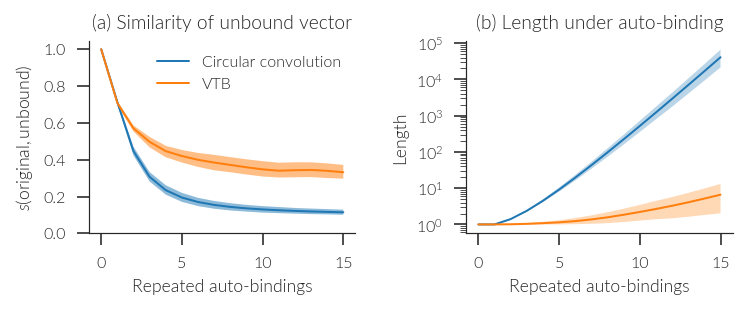

In [18]:
fig = plt.figure(figsize=(textwidth, row_height))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

for n, g in df.groupby('binding'):
    x = g.index.get_level_values('#bindings')
    ax1.plot(x, g['recall_cosines', 'mean'], label=n)
    ax1.fill_between(x, g['recall_cosines', 'ci_l'], g['recall_cosines', 'ci_u'], alpha=0.5)
    ax2.plot(x, g['lengths', 'mean'], label=n)
    ax2.fill_between(x, g['lengths', 'ci_l'], g['lengths', 'ci_u'], alpha=0.3)

ax1.set_ylim(bottom=0.)
ax1.set_title("(a) Similarity of unbound vector")
ax1.set_xlabel("Repeated auto-bindings")
ax1.set_ylabel(r"$s(\mathrm{original}, \mathrm{unbound})$")
ax1.legend() 

ax2.semilogy()
ax2.set_title("(b) Length under auto-binding")
ax2.set_xlabel("Repeated auto-bindings")
ax2.set_ylabel("Length")

sns.despine(fig)
fig.tight_layout()

In [19]:
save_tight_fig(fig, '../../../vtb-paper/figures/bindings-autoconv.pdf')

The length of the vector grows exponentially under circular convolution, but much slower with VTB. Similarly, the cosine angle of the original and recovered vector quickly approaches zero for the circular convolution binding, but stays slightly below 0.4 with VTB.

The next experiment looks at the same things, but binds random vectors together.

In [20]:
def random_bind_len(binding, d, n, seed=None):
    rng = np.random.RandomState(seed)
    gen = spa.vector_generation.UnitLengthVectors(d, rng)
    pointers = []
    bound = [binding.identity(d)]
    unbound = [binding.identity(d)]
    for i in range(n):
        pointers.append(spa.SemanticPointer(next(gen)))
        bound.append(binding.bind(bound[-1], pointers[-1]))
        inv = bound[-1]
        for p in reversed(pointers):
            inv = binding.unbind(inv, p)
        unbound.append(inv)
    return {
        '#bindings': list(range(n + 1)),
        'lengths': [x.length() for x in bound],
        'recall_cosines': [binding.identity(d).dot(x) / x.length() for x in unbound]
    }

In [21]:
pspace = Param(binding=(CircularConvolution(), VTB()), d=256, n=45) * Param(seed=range(15))

In [22]:
df = pd.DataFrame(flatten(map_pspace(random_bind_len, pspace)))

In [23]:
df = df[df['d'] == 256].groupby(('binding', '#bindings'), sort=False).agg(
    {'lengths': statistic(np.mean), 'recall_cosines': statistic(np.mean)})

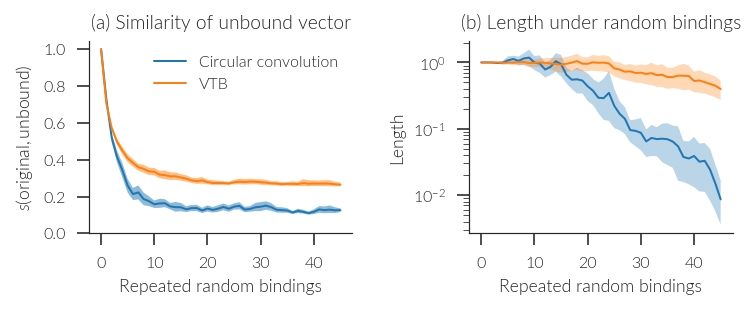

In [24]:
fig = plt.figure(figsize=(textwidth, row_height))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

for n, g in df.groupby('binding'):
    x = g.index.get_level_values('#bindings')
    ax1.plot(x, g['recall_cosines', 'mean'], label=n)
    ax1.fill_between(x, g['recall_cosines', 'ci_l'], g['recall_cosines', 'ci_u'], alpha=0.5)
    ax2.plot(x, g['lengths', 'mean'], label=n)
    ax2.fill_between(x, g['lengths', 'ci_l'], g['lengths', 'ci_u'], alpha=0.3)

ax1.set_ylim(bottom=0.)
ax1.set_title("(a) Similarity of unbound vector")
ax1.set_xlabel("Repeated random bindings")
ax1.set_ylabel(r"$s(\mathrm{original}, \mathrm{unbound})$")
ax1.legend()
    
ax2.semilogy()
ax2.set_title("(b) Length under random bindings")
ax2.set_xlabel("Repeated random bindings")
ax2.set_ylabel("Length")

sns.despine(fig)
fig.tight_layout()

In [25]:
save_tight_fig(fig, '../../../vtb-paper/figures/bindings-random.pdf')

In this case the vector length decays to zero for both binding methods, but more quickly with circular convolution. The cosine angle of the original and recovered vector decreases quickly towards zero for circular convolution. For VTB the asymptote is closer to 0.3.

One could assume that these problems vanish, when the vector is normalized in each binding step. So the following repeats the experiments with normalization.

In [26]:
def autobind_normalized_len(binding, d, n, seed=None):
    gen = spa.vector_generation.UnitLengthVectors(d, np.random.RandomState(seed))
    p = spa.SemanticPointer(next(gen))
    tag = spa.SemanticPointer(next(gen))
    bound = [binding.identity(d)]
    unbound = [binding.identity(d)]
    for i in range(1, n + 1):
        bound.append(binding.bind(bound[-1], tag).normalized())
        inv = bound[-1]
        for j in range(i):
            inv = binding.unbind(inv, tag).normalized()
        unbound.append(inv)
    return {
        '#bindings': list(range(n + 1)),
        'lengths': [x.length() for x in bound],
        'recall_cosines': [binding.identity(d).dot(x) / x.length() for x in unbound]
    }

In [27]:
pspace = Param(binding=(CircularConvolution(), VTB()), d=256, n=15) * Param(seed=range(15))

In [28]:
df_a = pd.DataFrame(flatten(map_pspace(autobind_normalized_len, pspace)))

In [29]:
df_a = df_a[df_a['d'] == 256].groupby(('binding', '#bindings'), sort=False).agg(
    {'lengths': statistic(np.mean), 'recall_cosines': statistic(np.mean)})

In [30]:
def random_bind_normalized_len(binding, d, n, seed=None):
    rng = np.random.RandomState(seed)
    pointers = []
    bound = [binding.identity(d)]
    unbound = [binding.identity(d)]
    for i in range(n):
        pointers.append(spa.SemanticPointer(next(spa.vector_generation.UnitLengthVectors(d, rng))))
        bound.append(binding.bind(bound[-1], pointers[-1]).normalized())
        inv = bound[-1]
        for p in reversed(pointers):
            inv = binding.unbind(inv, p).normalized()
        unbound.append(inv)
    return {
        '#bindings': list(range(n + 1)),
        'lengths': [x.length() for x in bound],
        'recall_cosines': [binding.identity(d).dot(x) / x.length() for x in unbound]
    }

In [31]:
pspace = Param(binding=(CircularConvolution(), VTB()), d=256, n=15) * Param(seed=range(15))

In [32]:
df_b = pd.DataFrame(flatten(map_pspace(random_bind_normalized_len, pspace)))

In [33]:
df_b = df_b[df_b['d'] == 256].groupby(('binding', '#bindings'), sort=False).agg(
    {'lengths': statistic(np.mean), 'recall_cosines': statistic(np.mean)})

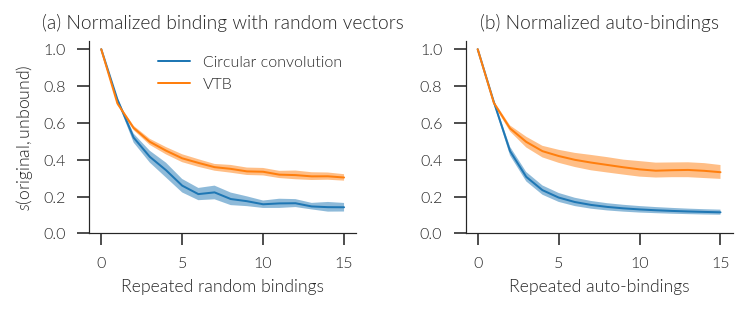

In [34]:
fig = plt.figure(figsize=(textwidth, row_height))

ax1 = fig.add_subplot(1, 2, 1)

for n, g in df_b.groupby('binding'):
    x = g.index.get_level_values('#bindings')
    ax1.plot(x, g['recall_cosines', 'mean'], label=n)
    ax1.fill_between(x, g['recall_cosines', 'ci_l'], g['recall_cosines', 'ci_u'], alpha=0.5)

ax1.set_ylim(bottom=0.)
ax1.set_title("(a) Normalized binding with random vectors")
ax1.set_xlabel("Repeated random bindings")
ax1.set_ylabel(r"$s(\mathrm{original}, \mathrm{unbound})$")
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)

for n, g in df_a.groupby('binding'):
    x = g.index.get_level_values('#bindings')
    ax2.plot(x, g['recall_cosines', 'mean'], label=n)
    ax2.fill_between(x, g['recall_cosines', 'ci_l'], g['recall_cosines', 'ci_u'], alpha=0.5)

ax2.set_ylim(bottom=0.)
ax2.set_title("(b) Normalized auto-bindings")
ax2.set_xlabel("Repeated auto-bindings")

sns.despine(fig)
fig.tight_layout()

In [35]:
save_tight_fig(fig, '../../../vtb-paper/figures/bindings-normalized.pdf')

This shows still the same decline in the cosine similarity with the recovered vector. Thus, while the normalization may keep the vector in the representational range of NEF ensembles, it does not allow to recover the bound vector more precisely. This is not surprising for compressed binding operations as there is no exact inverse in the general case.

For very low numbers of bindings it seems fine to use non-unitary vectors, but as soon as the number of bindings is a bit higher, unitary vectors should be used. In general VTB seems to be better suited for binding of non-unitary vectors. When binding larger numbers of non-unitary vectors, intermediary clean-up memories will be required for unbinding.

## Pairwise binding capacity

Chaining a lot of binding operations is not the only thing a binding operation should perform well on. In many cases multiple pairs of items need to be stored in a trace with the possibility to retrieve an item given its bound cue. The following experiment testing this is based on experiment 1 from the [Recchia et al. paper “Encoding sequential information in semantic space models: comparing holographic reduced representation and random permutation”](https://dl.acm.org/citation.cfm?id=2810688).

A vocabulary of 1000 items is created from which 500 pairs are sampled (with replacement). A number of these pairs is bound into a trace (encoding with binding) and then it is tested whether the element of a pair can be recovered given the other element.

In [36]:
def gen_vocab(d, m):
    """Generate a *d*-dimensional vocabulary of *m* semantic pointers (signal vectors) with Gaussian components."""
    vocab = spa.Vocabulary(d)
    for i in range(m):
        vocab.add('V' + str(i), spa.pointer.SemanticPointer(np.random.randn(d) / np.sqrt(d)))
    return vocab

In [37]:
class BindingExperiment(object):
    def __init__(self, d, m):
        self.d = d
        self.m = m
        self.vocab = gen_vocab(d, m)
        
    def get_p(self, i):
        """Return *i*-th semantic pointer."""
        return spa.SemanticPointer(self.vocab.vectors[i])
        
    def retrieval_accuracy(self, encoding_cls, k, n_pairs, n_trials):
        """Determine the retrieval average for *k* bound pairs sampled
        from *n_pairs* and averaged over *n_trials*."""
        # Sample pairs with replacement
        x_indices = np.random.randint(len(self.vocab), size=n_pairs)
        y_indices = np.random.randint(len(self.vocab), size=n_pairs)
        
        correct = 0
        for i in range(n_trials):
            encoding = encoding_cls()
            to_bind = np.random.randint(n_pairs, size=k)  # Sample k pairs for memory vector
            bound = encoding.bind(
                [self.get_p(x_indices[i]) for i in to_bind],
                [self.get_p(y_indices[i]) for i in to_bind])
            bound = bound.normalized()
            retrieval_idx = to_bind[np.random.randint(k)]
            retrieval_cue = self.get_p(y_indices[retrieval_idx])
            retrieved = encoding.retrieve(bound, retrieval_cue, self.vocab, k)
            correct += retrieved == x_indices[retrieval_idx]
            
        return correct / n_trials

### Encoding with binding

In [38]:
pspace = (
    Param(binding=[CircularConvolution(), VTB()]) *
    Param(d=[16 * 16, 22 * 22, 32 * 32, 45 * 45]) *
    Param(k=np.arange(2, 30, 4), m=1000, n_pairs=500, n_trials=1000))

In [39]:
def run_binding_experiment(d, k, m, n_pairs, n_trials, binding):
    return {'accuracy': BindingExperiment(d, m).retrieval_accuracy(
        EncodeWithBinding(binding, d), k, n_pairs, n_trials)}

filename = 'binding_experiment.pkl'
if os.path.exists(filename):
    df_b = pd.read_pickle(filename)
else:
    df_b = pd.DataFrame(map_pspace_parallel(run_binding_experiment, pspace, backend='threading'))
    df_b.to_pickle(filename)

In [40]:
l, u = proportion_confint(df_b['accuracy'] * df_b['n_trials'], df_b['n_trials'], method='beta')
df_b['accuracy_l'] = l
df_b['accuracy_u'] = u

df_b['accuracy_l'].fillna(0., inplace=True)
df_b['accuracy_u'].fillna(1., inplace=True)

### Encoding with tagging

Encoding with tagging performs worse than encoding with binding. Using a unitary circular convolution matrix, unitary vector-derived transformation matrix, a shift-by-one matrix, and orthogonal matrices all perform about the same. Because the matrix is repeatedly applied, using a non-unitary circular convolution matrix or a non-unitary vector-derived transformation matrix is detrimental.yy

In [41]:
class CircconvTagging(object):
    def __init__(self, unitary=True):
        self.unitary = unitary
        
    def __call__(self, d, k, m, n_pairs, n_trials):
        def EncodingCls():
            p = spa.SemanticPointer(next(spa.vector_generation.UnitLengthVectors(d)))
            if self.unitary:
                p = p.unitary()
            return EncodeWithTagging(p.get_binding_matrix())
        return {'accuracy': BindingExperiment(d, m).retrieval_accuracy(
            EncodingCls, k, n_pairs, n_trials)}
    
    def __str__(self):
        s = "Circular convolution"
        if self.unitary:
            s += " (unitary)"
        return s
    
    def __hash__(self):
        return hash(str(self))
    
    def __eq__(self, other):
        return isinstance(other, CircconvTagging) and self.unitary == other.unitary

In [42]:
class VtbTagging(object):
    def __init__(self, unitary=True):
        self.unitary = unitary
        
    def __call__(self, d, k, m, n_pairs, n_trials):
        def EncodingCls():
            if self.unitary:
                p = VTB().unitary(d, np.random)
            else:
                p = spa.SemanticPointer(next(spa.vector_generation.UnitLengthVectors(d, np.random)))
            mat = d**0.25 * np.kron(np.eye(int(np.sqrt(d))), p.v.reshape((int(np.sqrt(d)), int(np.sqrt(d)))))
            return EncodeWithTagging(mat)
        return {'accuracy': BindingExperiment(d, m).retrieval_accuracy(
            EncodingCls, k, n_pairs, n_trials)}
    
    def __str__(self):
        s = "VTB"
        if self.unitary:
            s += " (unitary)"
        return s

    def __hash__(self):
        return hash(str(self))

    def __eq__(self, other):
        return isinstance(other, VtbTagging) and self.unitary == other.unitary

In [43]:
class ShiftTagging(object):
    def __call__(self, d, k, m, n_pairs, n_trials):
        mat = np.roll(np.eye(d), -1, axis=0)
        return {'accuracy': BindingExperiment(d, m).retrieval_accuracy(
            EncodeWithTagging(mat, 30), k, n_pairs, n_trials)}
    
    def __str__(self):
        return "Shift"
    
    def __hash__(self):
        return hash(str(self))
    
    def __eq__(self, other):
        return isinstance(other, ShiftTagging)

In [44]:
class OrthogonalTagging(object):
    def __call__(self, d, k, m, n_pairs, n_trials):
        def EncodingCls():
            transformation = ortho_group.rvs(d)
            return EncodeWithTagging(transformation)
        return {'accuracy': BindingExperiment(d, m).retrieval_accuracy(
            EncodingCls, k, n_pairs, n_trials)}
    
    def __str__(self):
        return "Orthogonal matrix"

    def __hash__(self):
        return hash(str(self))
    
    def __eq__(self, other):
        return isinstance(other, OrthogonalTagging)

In [45]:
def run_tagging_experiment(method, **kwargs):
    return method(**kwargs)

In [46]:
pspace = (
    Param(method=[
        CircconvTagging(True), CircconvTagging(False),
        VtbTagging(True), VtbTagging(False),
        OrthogonalTagging(), ShiftTagging()]) *
    Param(d=[16 * 16, 22 * 22, 32 * 32, 45 * 45]) *
    Param(k=np.arange(2, 30, 4), m=1000, n_pairs=500, n_trials=1000))

In [47]:
filename = 'tagging_experiment.pkl'
if os.path.exists(filename):
    df_t = pd.read_pickle(filename)
else:
    df_t = pd.DataFrame(map_pspace_parallel(run_tagging_experiment, pspace, backend='threading'))
    df_t.to_pickle(filename)

In [48]:
l, u = proportion_confint(df_t['accuracy'] * df_t['n_trials'], df_t['n_trials'], method='beta')
df_t['accuracy_l'] = l
df_t['accuracy_u'] = u

df_t['accuracy_l'].fillna(0., inplace=True)
df_t['accuracy_u'].fillna(1., inplace=True)

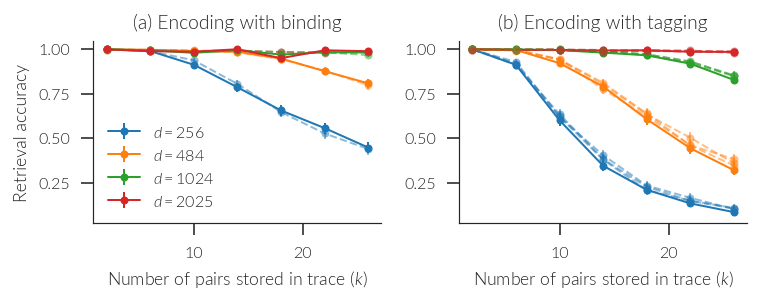

In [49]:
fig = plt.figure(figsize=(textwidth, row_height))

ax1 = fig.add_subplot(1, 2, 1)
for i, (n, g) in enumerate(df_b.groupby('binding', sort=False)):
    for d, hue_g in g.groupby('d'):
        ax1.errorbar(
            hue_g['k'], hue_g['accuracy'],
                yerr=(hue_g['accuracy'] - hue_g['accuracy_l'], hue_g['accuracy_u'] - hue_g['accuracy']),
            fmt='--' if n == CircularConvolution() else '-',
            alpha=0.5 if n == CircularConvolution() else 1.,
            marker='o', label="$d = {}$".format(d) if n == VTB() else None)
        labeled = True
    ax1.set_prop_cycle(None)
    
ax1.set_ylim(bottom=0.)
ax1.legend()
ax1.set_title("(a) Encoding with binding")
ax1.set_xlabel("Number of pairs stored in trace ($k$)")
ax1.set_ylabel("Retrieval accuracy")

xs = df_t[df_t['method'].isin([CircconvTagging(True), VtbTagging(True), ShiftTagging(), OrthogonalTagging()])]
styles = {VtbTagging(True): '-', CircconvTagging(True): '--', ShiftTagging(): '--', OrthogonalTagging(): '--'}
ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
for i, (n, g) in enumerate(xs.groupby('method', sort=False)):
    for d, hue_g in g.groupby('d'):
        hue_g = hue_g.sort_values('k')
        ax2.errorbar(
            hue_g['k'], hue_g['accuracy'],
                yerr=(hue_g['accuracy'] - hue_g['accuracy_l'], hue_g['accuracy_u'] - hue_g['accuracy']),
            fmt=styles[n], alpha=0.5 if not isinstance(n, VtbTagging) else 1.,
            marker='o', label="$d = {}$".format(d) if n == VtbTagging(True) else None)
        labeled = True
    ax2.set_prop_cycle(None)
    
ax2.set_title("(b) Encoding with tagging")
ax2.set_xlabel("Number of pairs stored in trace ($k$)")

sns.despine(fig)
fig.tight_layout()

In [50]:
save_tight_fig(fig, '../../../vtb-paper/figures/encoding.pdf')

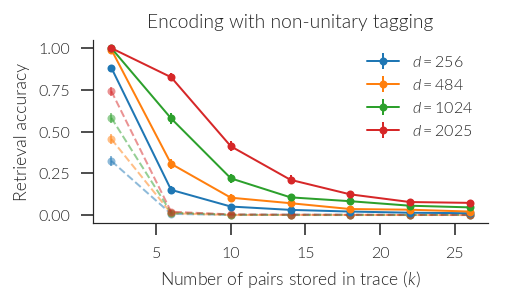

In [51]:
fig = plt.figure(figsize=single_fig_size)

xs = df_t[df_t['method'].isin([CircconvTagging(False), VtbTagging(False)])]
styles = {VtbTagging(False): '-', CircconvTagging(False): '--'}

ax = fig.add_subplot(1, 1, 1)
for i, (n, g) in enumerate(xs.groupby('method', sort=False)):
    for d, hue_g in g.groupby('d'):
        hue_g = hue_g.sort_values('k')
        ax.errorbar(
            hue_g['k'], hue_g['accuracy'],
                yerr=(hue_g['accuracy'] - hue_g['accuracy_l'], hue_g['accuracy_u'] - hue_g['accuracy']),
            fmt=styles[n], alpha=0.5 if not isinstance(n, VtbTagging) else 1.,
            marker='o', label="$d = {}$".format(d) if n == VtbTagging(False) else None)
        labeled = True
    ax.set_prop_cycle(None)

ax.legend()
ax.set_title("Encoding with non-unitary tagging")
ax.set_xlabel("Number of pairs stored in trace ($k$)")
ax.set_ylabel("Retrieval accuracy")

sns.despine(fig)
fig.tight_layout()

In [52]:
save_tight_fig(fig, '../../../vtb-paper/figures/encoding-nonunitary-tagging.pdf')

# Stack

In [53]:
def test_stack(binding, d, enc_depth, ret_depth, trial=None):
    rng = np.random.RandomState(trial)
    vocab = spa.Vocabulary(d, pointer_gen=spa.vector_generation.UnitLengthVectors(rng))
    vocab.populate('TAG')
    vocab.populate(';'.join('V' + str(i) for i in range(enc_depth + 1)))
    p = vocab['V0']
    for i in range(1, enc_depth + 1):
        p = binding.bind(p, vocab['TAG']) + vocab['V' + str(i)]
    for i in range(ret_depth):
        p = binding.unbind(p, vocab['TAG'])
    target = 'V' + str(enc_depth - ret_depth)
    sim = p.compare(vocab[target])
    sim_max = np.max(vocab.dot(p.normalized()))
    correct = list(vocab.keys())[np.argmax(vocab.dot(p.normalized()))] == target
    return {'sim': sim,
            'sim_max': sim_max,
            'correct': correct}

In [54]:
pspace = (
    Param(binding=[CircularConvolution(), VTB()]) *
    Param(d=[16 * 16, 22 * 22, 32 * 32, 45 * 45]) *
    sum((Param(enc_depth=i, ret_depth=list(range(i + 1))) for i in range(1, 7)), Param()) *
    Param(trial=np.arange(50)))

In [55]:
filename = 'stack_experiment.pkl'
if os.path.exists(filename):
    df = pd.read_pickle(filename)
else:
    df = pd.DataFrame(map_pspace(test_stack, pspace))
    df.to_pickle(filename)

In [56]:
df['n'] = df['enc_depth'] + 1

In [57]:
df['rho'] = -df['ret_depth']

In [58]:
df_cc = df[df['binding'] == CircularConvolution()].query('d == 2025')
df_vtb = df[df['binding'] == VTB()].query('d == 2025')

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


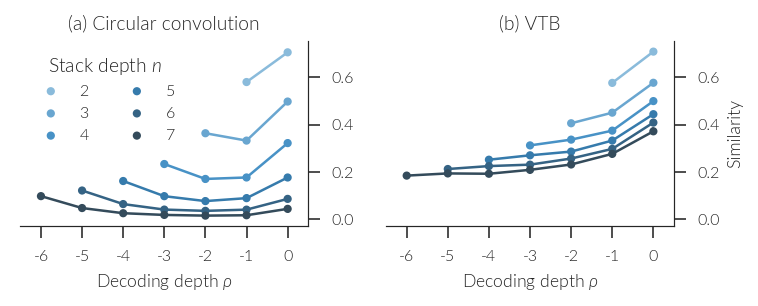

In [59]:
fig = plt.figure(figsize=(textwidth, row_height))

cp = sns.color_palette('Blues_d', len(df['enc_depth'].unique()))
cp.reverse()

ax1 = fig.add_subplot(1, 2, 1)
sns.pointplot(x='rho', y='sim', hue='n', data=df_cc, ax=ax1, palette=cp, scale=.7)
ax1.legend(ncol=2, title="Stack depth $n$")
ax1.yaxis.get_label().set_visible(False)
ax1.set_title("(a) Circular convolution")
ax1.set_xlabel(r"Decoding depth $\rho$")

ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)
sns.pointplot(x='rho', y='sim', hue='n', data=df_vtb, ax=ax2, palette=cp, scale=.7)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.legend().remove()
ax2.set_title("(b) VTB")
ax2.set_xlabel(r"Decoding depth $\rho$")
ax2.set_ylabel("Similarity")


sns.despine(fig, left=True, right=False)
fig.tight_layout()

In [60]:
save_tight_fig(fig, '../../../vtb-paper/figures/stack.pdf')

In [61]:
for i in range(2, 8):
    g = df_cc.query('n == {}'.format(i)).groupby(['rho', 'enc_depth'])['sim']
    cc = (g.mean() - 1.645 * g.std()).min()
    print('{}: {!r},'.format(i, cc))

2: 0.5579481179146595,
3: 0.29241144039321426,
4: 0.11418067597602344,
5: 0.033746530261135436,
6: -0.006885981292808013,
7: -0.0216477933456276,


In [62]:
for i in range(2, 8):
    g = df_vtb.query('n == {}'.format(i)).groupby(['rho', 'enc_depth'])['sim']
    vtb = (g.mean() - 1.645 * g.std()).min()
    print('{}: {!r},'.format(i, vtb))

2: 0.555179340605646,
3: 0.37701993583903615,
4: 0.2749751969505107,
5: 0.2159885216534928,
6: 0.17566487134716197,
7: 0.14305184430252316,
